# In situ validation data

Download data corresponding to LAI measurements

In [1]:
import os
from pathlib import Path
import sys
base_dir = Path(os.path.dirname(os.path.realpath("__file__"))).parent.parent
sys.path.insert(0, os.path.join(base_dir, "eodal"))
import eodal
from eodal.config import get_settings
from eodal.core.scene import SceneCollection
from eodal.core.sensors.sentinel2 import Sentinel2
from eodal.mapper.feature import Feature
from eodal.mapper.filter import Filter
from eodal.mapper.mapper import Mapper, MapperConfigs

Settings = get_settings()
# set to False to use a local data archive
Settings.USE_STAC = True

import geopandas as gpd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import contextily as ctx
import pandas as pd
from scipy.spatial import cKDTree
from shapely.geometry import Point
from geopy.distance import geodesic
from pyproj import Proj, transform
from shapely.ops import transform
from shapely.geometry import box
import pyproj

In [2]:
lai_path = base_dir.joinpath('data/in-situ_glai.gpkg')
gdf = gpd.read_file(lai_path)
#gdf.head()

In [3]:
# Keep only locations of interest
gdf = gdf[gdf.location.isin(['Strickhof', 'SwissFutureFarm', 'Witzwil'])]

In [4]:
# Get S2 spectra for pixels if they are cloud free
# Craete pairs lai-spectra
# Apply models and compute RMSE

In [5]:
def preprocess_sentinel2_scenes(
    ds: Sentinel2,
    target_resolution: int,
) -> Sentinel2:
    """
    Resample Sentinel-2 scenes and mask clouds, shadows, and snow
    based on the Scene Classification Layer (SCL).

    NOTE:
        Depending on your needs, the pre-processing function can be
        fully customized using the full power of EOdal and its
    interfacing libraries!

    :param target_resolution:
        spatial target resolution to resample all bands to.
    :returns:
        resampled, cloud-masked Sentinel-2 scene.
    """
    # resample scene
    ds.resample(inplace=True, target_resolution=target_resolution)
    # mask clouds, shadows, and snow
    ds.mask_clouds_and_shadows(inplace=True, cloud_classes=[3, 8, 9, 10, 11])
    return ds
    

def extract_s2_data(
        aoi: gpd.GeoDataFrame,
        time_start: datetime,
        time_end: datetime,
        scene_cloud_cover_threshold: float = 80,
        feature_cloud_cover_threshold: float = 50,
        spatial_resolution: int = 10
    ) -> SceneCollection:
    """
    Extracts Sentinel-2 data from the STAC SAT archive for a given area and time period.
    Scenes that are too cloudy or contain nodata (blackfill), only, are discarded.

    The processing level of the Sentinel-2 data is L2A (surface reflectance factors).

    :param parcel:
        field parcel geometry (defines the spatial extent to extract)
    :param time_start:
        start of the time period to extract
    :param end_time:
        end of the time period to extract
    :param scene_cloud_cover_threshold:
        scene-wide cloudy pixel percentage (from Sentinel-2 metadata) to filter out scenes
        with too high cloud coverage values [0-100%]
    :param feature_cloud_cover_threshold:
        cloudy pixel percentage [0-100%] on the parcel level. Only if the parcel has a
        lower percentual share of cloudy pixels (based on the scene classification layer) than
        the threshold specified, the Sentinel-2 observation is kept
    :param spatial_resolution:
        spatial resolution of the Sentinel-2 data in meters (Def: 10m)
    :param resampling_method:
        spatial resampling method for those Sentinel-2 bands not available in the target
        resolution. Nearest Neighbor by default
    :returns:
        dictionary with the list of scenes for the field parcel (`feature_scenes`), the
        DataFrame of (un)used scenes and the reason for not using plus some basic scene
        metadata (`scene_properties`)
    """
    # setup the metadata filters (cloud cover and processing level)
    metadata_filters = [
        Filter('cloudy_pixel_percentage','<', scene_cloud_cover_threshold),
        Filter('processing_level', '==', 'Level-2A')
    ]
    # setup the spatial feature for extracting data
    feature = Feature.from_geoseries(aoi.geometry)
    
    # set up mapping configs
    mapper_configs = MapperConfigs(
        collection='sentinel2-msi',
        time_start=time_start,
        time_end=time_end,
        feature=feature,
        metadata_filters=metadata_filters
    )

    # get a new mapper instance. Set sensor to `sentinel2`
    mapper = Mapper(mapper_configs)

    # query the STAC (looks for available scenes in the selected spatio-temporal range)
    mapper.query_scenes()

    # get observations (loads the actual Sentinel2 scenes)
    # the data is extract for the extent of the parcel
    scene_kwargs = {
        'scene_constructor': Sentinel2.from_safe,            # this tells the mapper how to read and load the data (i.e., Sentinel-2 scenes)
        'scene_constructor_kwargs': {'band_selection': ['B01','B02','B03', 'B04', 'B05', 'B06', 'B07', 'B08','B8A', 'B11', 'B12', 'SCL']},                     # here you could specify which bands to read
        'scene_modifier': preprocess_sentinel2_scenes,       # this tells the mapper about (optional) pre-processing of the loaded scenes (must be a callable)
        'scene_modifier_kwargs': {'target_resolution': spatial_resolution}   # here, you have to specify the value of the arguments the `scene_modifier` requires
    }
    mapper.load_scenes(scene_kwargs=scene_kwargs)

    # loop over available Sentinel-2 scenes stored in mapper.data as a EOdal SceneCollection and check
    # for no-data. These scenes will be removed from the SceneCollection
    scenes_to_del = []
    mapper.metadata['scene_used'] = 'yes'

    """
    if mapper.data is not None:
        for scene_id, scene in mapper.data:

            # check if scene is blackfilled (nodata); if yes continue
            if scene.is_blackfilled:
                scenes_to_del.append(scene_id)
                mapper.metadata.loc[mapper.metadata.sensing_time.dt.strftime('%Y-%m-%d %H:%M') == scene_id.strftime('%Y-%m-%d %H:%M')[0:16], 'scene_used'] = 'No [blackfill]'
                continue

            # check cloud coverage (including shadows and snow) of the field parcel
            feature_cloud_cover = scene.get_cloudy_pixel_percentage(cloud_classes=[3, 8, 9, 10, 11])

            # if the scene is too cloudy, we skip it
            if feature_cloud_cover > feature_cloud_cover_threshold:
                scenes_to_del.append(scene_id)
                mapper.metadata.loc[mapper.metadata.sensing_time.dt.strftime('%Y-%m-%d %H:%M') == scene_id.strftime('%Y-%m-%d %H:%M')[0:16], 'scene_used'] = 'No [clouds]'
                continue

        # delete scenes containing only no-data
        for scene_id in scenes_to_del:
            del mapper.data[scene_id]
    """

    
    return mapper

### Querying points with EOdal

In [ ]:
# Check the bounding box created by EOdal

points = gdf.head(1).dissolve()
feature = Feature.from_geoseries(points.geometry)
feature_wgs84 = feature.to_epsg(3857)
# Create a box of 10m resolution around point
resolution = 100
bbox = box(feature_wgs84.geometry.x - resolution/2, feature_wgs84.geometry.y - resolution/2,
          feature_wgs84.geometry.x + resolution/2, feature_wgs84.geometry.y + resolution/2)
# Project back to EPSG 4326
projector = pyproj.Transformer.from_crs('EPSG:3857', 'EPSG:4326', always_xy=True).transform
bbox = transform(projector, bbox)        

bbox_gds = gpd.GeoSeries([bbox])
bbox_gdf = gpd.GeoDataFrame(bbox_gds, columns=['geometry'])
bbox_gdf = bbox_gdf.set_crs('EPSG:4326')


fig, axs = plt.subplots(1,1)
bbox_gdf.plot(ax=axs, label='EOdal bbox', color='red')
points.to_crs(bbox_gdf.crs).plot(ax=axs, label='In situ')
plt.legend()
plt.show()

### Sampling single point

In [8]:
s2_data = extract_s2_data(
  aoi=gdf.head(1).dissolve(),
  time_start=datetime(2017,3,1),
  time_end=datetime(2017,5,31)
)

is point


2024-02-09 13:51:34,551 eodal        INFO     Starting extraction of sentinel2 scenes


None


2024-02-09 13:51:59,909 eodal        INFO     Finished extraction of sentinel2 scenes


In [9]:
for scene_id, scene in s2_data.data:
  pixs = scene.to_dataframe()
  print(len(pixs))
  break

35


In [28]:
bbox.bounds

(8.688959872411019, 47.44658785830815, 8.68904970393943, 47.44664860928909)

<Axes: >

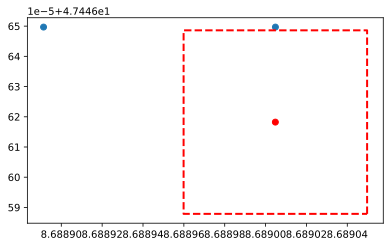

In [30]:
# Lukas' method: clip scene to buffered point (the bbox in this case)

points = gdf.head(1).dissolve()
feature = Feature.from_geoseries(points.geometry)
feature_wgs84 = feature.to_epsg(3857) # to metric
# Create a box of 10m resolution around point
resolution = 10
bbox = box(feature_wgs84.geometry.x - resolution/2, feature_wgs84.geometry.y - resolution/2,
          feature_wgs84.geometry.x + resolution/2, feature_wgs84.geometry.y + resolution/2)
projector = pyproj.Transformer.from_crs('EPSG:3857', 'EPSG:4326', always_xy=True).transform
bbox = transform(projector, bbox) 

scene.clip_bands(clipping_bounds=bbox.bounds, inplace=True)
pixs_clipped = scene.to_dataframe()

fig, axs = plt.subplots(1,1)
pixs_clipped.plot(ax=axs, label='EOdal')
gdf.head(1).to_crs(pixs_clipped.crs).plot(ax=axs, color='r')
gpd.GeoSeries(bbox).set_crs(pixs_clipped.crs).plot(ax=axs, facecolor='none', edgecolor='red', linewidth=2, linestyle='dashed')
#gpd.GeoSeries(bbox).set_crs(gdf.crs).buffer(-13).to_crs(pixs.crs).plot(ax=axs, facecolor='none', edgecolor='red', linewidth=2, linestyle='dashed')
#gpd.GeoSeries(bbox).set_crs(gdf.crs).to_crs(pixs.crs).plot(ax=axs, facecolor='none', edgecolor='red', linewidth=2)

In [13]:
print(type(scene))

<class 'eodal.core.sensors.sentinel2.Sentinel2'>


<Axes: >

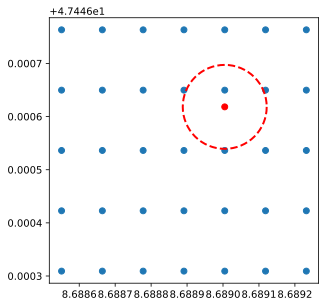

In [11]:
fig, axs = plt.subplots(1,1)
pixs.plot(ax=axs, label='EOdal')
gdf.head(1).to_crs(pixs.crs).plot(ax=axs, color='r')
bbox = box(*gdf.head(1).total_bounds)
buffered_bbox = bbox.buffer(10)
gpd.GeoSeries(bbox).set_crs(gdf.crs).buffer(13).to_crs(pixs.crs).plot(ax=axs, facecolor='none', edgecolor='red', linewidth=2, linestyle='dashed')
#gpd.GeoSeries(bbox).set_crs(gdf.crs).buffer(-13).to_crs(pixs.crs).plot(ax=axs, facecolor='none', edgecolor='red', linewidth=2, linestyle='dashed')
gpd.GeoSeries(bbox).set_crs(gdf.crs).to_crs(pixs.crs).plot(ax=axs, facecolor='none', edgecolor='red', linewidth=2)

### Sampling multiple points

In [ ]:
s2_data = extract_s2_data(
  aoi=gdf.head(10).dissolve(),
  time_start=datetime(2017,3,1),
  time_end=datetime(2017,5,31)
)

In [ ]:
points = gdf.head(10).dissolve()
feature = Feature.from_geoseries(points.geometry)
feature.to_geoseries()

vector_features_df = gpd.GeoDataFrame(geometry=feature.to_geoseries().copy())
vector_features_df.to_crs(crs=32632, inplace=True)
vector_features_df.total_bounds

In [ ]:
for scene_id, scene in s2_data.data:
  pixs = scene.to_dataframe()
  print(len(pixs))
  break

In [ ]:
fig, axs = plt.subplots(1,1)
pixs.plot(ax=axs, label='EOdal')
gdf.head(10).to_crs(pixs.crs).plot(ax=axs, color='r')
bbox = box(*gdf.head(10).total_bounds)
buffered_bbox = bbox.buffer(10)
gpd.GeoSeries(bbox).set_crs(gdf.crs).buffer(13).to_crs(pixs.crs).plot(ax=axs, facecolor='none', edgecolor='red', linewidth=2, linestyle='dashed')
gpd.GeoSeries(bbox).set_crs(gdf.crs).buffer(-13).to_crs(pixs.crs).plot(ax=axs, facecolor='none', edgecolor='red', linewidth=2, linestyle='dashed')
gpd.GeoSeries(bbox).set_crs(gdf.crs).to_crs(pixs.crs).plot(ax=axs, facecolor='none', edgecolor='red', linewidth=2)

#s2_data.metadata.plot(ax=axs) # metadata is in 4326 even though says otherwise
#pixs.to_crs(s2_data.metadata.crs).plot(ax=axs, label='EOdal', color='r')
#gdf.head(10).to_crs(s2_data.metadata.crs).plot(ax=axs, color='g', alpha=0.2)

### Get S2 data for all in-situ dates possible 

In [ ]:
gdf_date = gdf.head(2)
gdf_date = gdf_date.to_crs('EPSG:4326')
pixs = pixs.to_crs('EPSG:4326')

In [ ]:
def find_nearest(point, tree):
    ''' 
    Find the nearest point in pixs for each point in gdf_date
    '''
    _, index = tree.query((point.x, point.y))
    return pixs.iloc[index]

def compute_distance(row):
    return geodesic((row['geometry'].y, row['geometry'].x), (row['geometry_s2'].y, row['geometry_s2'].x)).meters

In [ ]:
# Loop over dates of val data
# Query s2 data for those dates
# Keep pixel closest to geom

val_df = pd.DataFrame()

for d in gdf['date']:
  try:
    s2_data = extract_s2_data(
      aoi=gdf.dissolve(),
      time_start=pd.to_datetime(d), 
      time_end=pd.to_datetime(d) + timedelta(days=1)
    )
  except:
    pass
    
  if s2_data.data is not None:
    for scene_id, scene in s2_data.data:
      pixs = scene.to_dataframe()
      pixs = pixs.to_crs('EPSG:4326')
      
      # Find S2-data closest (within 10m) to validation data for that date
      gdf_date = gdf[gdf['date'] == d]
      gdf_date = gdf.date.to_crs(pixs.crs) # to meters, EPSG:32632

      pixs_tree = cKDTree(pixs['geometry'].apply(lambda geom: (geom.x, geom.y)).tolist())

      # Apply the function to each point in gdf_date
      nearest_points = gdf_date['geometry'].apply(lambda point: find_nearest(point, pixs_tree))
      nearest_points = nearest_points.rename(columns={'geometry': 'geometry_s2'})
      gdf_date = pd.concat([gdf_date[['date', 'lai', 'location', 'geometry']], nearest_points], axis=1)

      # # Keep if less than 10m away to ensure its the right pixel
      gdf_date['distance'] = gdf_date.apply(compute_distance, axis=1)      
      gdf_date = gdf_date[gdf_date['distance'] <10]
      
      # Save lai and spectra 
      if (len(gdf_date)):
        val_df = pd.concat([val_df, gdf_date[['lai', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12',]]])



# Save in-situ val data
data_path = base_dir.joinpath(f'results/validation_data.pkl')
with open(data_path, 'wb+') as dst:
    pickle.dump(val_df, dst)


In [31]:
# Check saved val data
import pickle

data_path = base_dir.joinpath(f'results/validation_data.pkl')
with open(data_path, 'rb+') as dst:
    val_df = pickle.load(dst)

In [32]:
val_df


,lai,B02,B03,B04,B05,B06,B07,B08,B8A,B11,B12,geometry,date,location
26,4.20,0.0154,0.0290,0.0163,0.0534,0.2640,0.4153,0.4140,0.4267,0.1157,0.0569,POINT (8.68890 47.44659),2022-05-13 12:38:35,Strickhof
30,6.70,0.0287,0.0538,0.0257,0.0843,0.3297,0.4732,0.5048,0.4911,0.1443,0.0785,POINT (8.68890 47.44664),2022-06-10 12:48:25,Strickhof
31,4.61,0.0324,0.0554,0.0429,0.0904,0.2876,0.4164,0.4284,0.4396,0.1427,0.0772,POINT (8.68888 47.44666),2022-06-17 13:35:34,Strickhof
35,3.61,0.0179,0.0308,0.0185,0.0511,0.2633,0.4092,0.4196,0.4281,0.1132,0.0549,POINT (8.68910 47.44627),2022-05-13 12:52:50,Strickhof
39,4.19,0.0410,0.0725,0.0628,0.1259,0.3448,0.4680,0.4992,0.4966,0.1800,0.1046,POINT (8.68908 47.44637),2022-06-10 13:37:53,Strickhof
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,4.97,0.0216,0.0378,0.0198,0.0609,0.2735,0.4145,0.4080,0.4304,0.1171,0.0567,POINT (8.90665 47.47479),2022-05-19 10:51:17,SwissFutureFarm
241,4.79,0.0391,0.0573,0.0399,0.0899,0.3218,0.4577,0.4508,0.4860,0.1478,0.0697,POINT (8.90553 47.47480),2022-06-20 11:11:29,SwissFutureFarm
242,3.44,0.0150,0.0400,0.0180,0.0652,0.3177,0.4524,0.4556,0.4597,0.1277,0.0563,POINT (8.90550 47.47466),2022-05-11 13:53:27,SwissFutureFarm
244,4.89,0.0380,0.0565,0.0339,0.0874,0.3653,0.5475,0.5448,0.5810,0.1539,0.0701,POINT (8.90548 47.47476),2022-06-15 10:35:02,SwissFutureFarm


In [33]:
len(val_df)

80

In [ ]:
len(gdf)

# Fabio's greentrack code

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
font = {'family' : 'DejaVu Sans',
        'size'   : 14}
from matplotlib import rc
rc('font', **font)
import geopandas as gpd
from datetime import datetime, timedelta

import os
from pathlib import Path
import sys
base_dir = Path(os.path.dirname(os.path.realpath("__file__"))).parent.parent
sys.path.insert(0, os.path.join(base_dir, "eodal"))
import eodal
from eodal.config import get_settings
from eodal.core.sensors.sentinel2 import Sentinel2
from eodal.mapper.feature import Feature
from eodal.mapper.filter import Filter
from eodal.mapper.mapper import Mapper, MapperConfigs
from pathlib import Path
from typing import List
from pandas import Series #, concat
import geopandas
from scipy.interpolate import interp2d
import re
import os
from datetime import datetime as dt 
from scipy.optimize import curve_fit

# STAC PROTOCOL SETTINGS: set to False to use a local data archive
Settings = get_settings()
Settings.USE_STAC = True

In [ ]:
# remove all pattern-matching files
def purge(target_dir, target_pattern): 
    for f in os.listdir(target_dir):
        if re.search(target_pattern, f):
            os.remove(os.path.join(target_dir, f))

def preprocess_sentinel2_scenes(
    ds: Sentinel2, # this is a scene, i.e. a RasterCollection object
    target_resolution: int, 
    
    # ADD HERE MORE ARGUMENTS (E.G.packages for preprocessing the images) 
    # and add these also in the dictionary below  'scene_modifier_kwargs'
    ) -> Sentinel2:
    """
    Resample Sentinel-2 scenes and mask clouds, shadows, and snow
    # resample scene
    .resample(inplace=True, target_resolution=target_resolution)
    
    ask clouds, shadows, and snowbased on the Scene Classification Layer (SCL).
    
    	NOTE:
    		Depending on your needs, the pre-processing function can be
    		fully customized using the full power of EOdal and its
    		interfacing libraries!
    
    	:param target_resolution:
    		spatial target resolution to resample all bands to.
    	:returns:
    		resampled, cloud-masked Sentinel-2 scene.
	"""
    
    # resample scene
    ds.resample(inplace=True, target_resolution=target_resolution) 
    
    # mask clouds, shadows, but leave snow (class 11), see page 304 https://sentinel.esa.int/documents/247904/685211/sentinel-2-products-specification-document
    # Label Classification
    # 0 NO_DATA
    # 1 SATURATED_OR_DEFECTIVE
    # 2 DARK_AREA_PIXELS
    # 3 CLOUD_SHADOWS
    # 4 VEGETATION
    # 5 BARE_SOILS
    # 6 WATER
    # 7 UNCLASSIFIED 
    # 8 CLOUD_MEDIUM_PROBABILITY
    # 9 CLOUD_HIGH_PROBABILITY 
    # 10 THIN_CIRRUS
    # 11 SNOW /ICE
    
    ds.mask_clouds_and_shadows(inplace=True, cloud_classes=[1, 2, 3, 7, 8, 9, 10])   # MASKED BY EODAL
    
    return ds

def scene_to_array(sc,tx,ty):
    """
    Generate an numpy array (image stack) from a given Eodal SceneCollection.
    The scenes are resampled on a costant coordinate grid allowing pixel analysis.
    Missing data location are marked as nans.

    Parameters
    ----------
    sc : Eodal SceneCollection
        The given Scene Collection generated from Eodal
    tx : Float Vector
        x coordinate vector for the resample grid.
        ex. tx = numpy.arange(100,150,10) # x coords from 100 to 150 with 10 resolution
    ty : Float Vector
        y coordinate vector for the resample grid.

    Returns
    -------
    im : float 4D numpy array.
        Array containing the stack of all scenes.
        4 dimensions: [x, y, bands, scenes]

    """
    
    ts = sc.timestamps # time stamps for each image
    bands = sc[sc.timestamps[0]].band_names # bands
    im_size = [len(ty),len(tx)] # image size
    im = np.empty(np.hstack([im_size,len(bands),len(ts)])) # preallocate matrix

    for i, scene_iterator in enumerate(sc):
        
        # REGRID SCENE TO BBOX AND TARGET RESOLUTION
        scene = scene_iterator[1]        
        for idx, band_iterator in enumerate(scene):
            
            # extract data with masked ones = 0
            band = band_iterator[1]
            Gv = np.copy(band.values.data)             
            Gv[band.values.mask==1]=0
            
            #original grid coordinates
            ny,nx = np.shape(Gv)
            vx = band.coordinates['x']
            vy = band.coordinates['y']
           
            # create interpolator
            
            Gv_no_nans = Gv.copy()
            Gv_no_nans[np.isnan(Gv)] = 0
            f = interp2d(vx,vy,Gv_no_nans,kind='linear',fill_value=0)
            
            # interpolate band on the target grid
            Tv = np.flipud(f(tx,ty))
            
             # assign interpolated band [i = scene , b = band]
            im[:,:,idx,i] = Tv.copy()
            del Tv
    
    return im

def imrisc(im,qmin=1,qmax=99): 
    """
    Percentile-based 0-1 rescale for multiband images

    Parameters
    ----------
    im : Float Array
        The image to rescale, can be multiband on the 3rd dimension
    qmin : Float Scalar
        Percentile to set the bottom of the value range e.g. 0.01
    qmax : Float Scalar
        Percentile to set the top of the value range e.g. 0.99

    Returns
    -------Quantile
    im_out : Float Array
        Rescaled image

    """

    if len(np.shape(im))==2:
        band=im.copy()
        band2=band[~np.isnan(band)]
        vmin=np.percentile(band2,qmin)
        vmax=np.percentile(band2,qmax)
        band[band<vmin]=vmin
        band[band>vmax]=vmax
        band=(band-vmin)/(vmax-vmin)
        im_out=band
    else:
        im_out=im.copy()
        for i in range(np.shape(im)[2]):
            band=im[:,:,i].copy()
            band2=band[~np.isnan(band)]
            vmin=np.percentile(band2,qmin)
            vmax=np.percentile(band2,qmax)
            band[band<vmin]=vmin
            band[band>vmax]=vmax
            band=(band-vmin)/(vmax-vmin)
            im_out[:,:,i]=band
            
    return im_out

In [ ]:
#%% INPUT PARAMS

## HERE you can create a loop to run all following code for a list of sites (parcels)
# giving SITE_NAME a different name every loop iteration

SITE_NAME = 'strickhof' # base name for output files and folder

# file path of the bounding box (can be geopackage or shapefile with related files)
bbox_fname = '../../data/Strickhof.shp' # should be in metric crs

# list  of years you want the data for, can also contain one year
year_list = [2016] # [2016,2017,2018]

# local path where output directory and files are saved
SAVE_DIR = '../../results' # 

# coudy pixel percentage to discard sentinel tiles
CLOUD_TH = 30

# sentinel product name
S_NAME = 'sentinel2-msi'

# bands to select (list)
# See available bands for sentinel-2 L2A here:
# https://docs.sentinel-hub.com/api/latest/data/sentinel-2-l2a/
# SCL (Scene Classification Layer) is added as extra band

BAND_LIST = [
# 'B01',
'B02', # RGB
'B03',
'B04',
# 'B05',
# 'B06',
# 'B07',
'B08', # NIR
# 'B8A',
# 'B09',
# 'B11',
# 'B12'
]

# Reuse existing data: If set to True, the script will look for already downloaded images
# present in SAVE_DIR for SITE_NAME and YEAR. If False all images will be dowloaded
# from scratch
 
REUSE_DATA = False

In [ ]:
for k in range(len(year_list)):
    
    YEAR = year_list[k]
    
    print('#### Extracting data for site ' + SITE_NAME + ' year ' + str(YEAR))
    
    #% (EDIT) EODAL QUERY PARAMETERS
       
    # user-inputs
    # -------------------------- Collection -------------------------------
    collection: str = S_NAME
    
    # ------------------------- Time Range ---------------------------------
    time_start: datetime = datetime(YEAR,1,1)  		# year, month, day (incl.)
    time_end: datetime = datetime(YEAR,12,31)     	# year, month, day (incl.)
    
    # ---------------------- Spatial Feature  ------------------------------
    geom: Path = Path(bbox_fname) # BBOX as geometry for the query
    	
    # ------------------------- Metadata Filters ---------------------------
    metadata_filters: List[Filter] = [
      	Filter('cloudy_pixel_percentage','<', CLOUD_TH),
      	Filter('processing_level', '==', 'Level-2A')
        ]
    
    #  ---------------------- query params for STAC  ------------------------------
    
    scene_kwargs = {
        'scene_constructor': Sentinel2.from_safe,
        'scene_constructor_kwargs': {'band_selection': BAND_LIST},
        'scene_modifier': preprocess_sentinel2_scenes,
        'scene_modifier_kwargs': {'target_resolution': 10}
    }
        
    feature = Feature.from_geoseries(gpd.read_file(geom).to_crs('EPSG:32632').geometry)
    
    #% DOWNLOAD THE IMAGES
    
    # path where results are saved
    OUT_PATH = SAVE_DIR + '/' + SITE_NAME + '_' + str(YEAR)
    print(OUT_PATH)
    if not os.path.exists(OUT_PATH):
        os.makedirs(OUT_PATH)
    
    # subfolder where sat images and temp data are saved
    DATA_PATH = OUT_PATH + '/data'
    print(DATA_PATH)
    if not os.path.exists(DATA_PATH):
        os.makedirs(DATA_PATH)    
    
    # split the wanted date range in approx 30-day chuncks to override download limit
    
    CHUNK_SIZE = 30
    date_vec = [time_start]
    date_new = time_start + timedelta(days = CHUNK_SIZE)
    n = 1
    while date_new < time_end and n < 100: # max 100 chunks
        date_vec.append(date_new)
        date_new = date_new + timedelta(days = CHUNK_SIZE)        
        n = n+1
    date_vec.append(time_end)
        
    
    #% define target grid based on original bbox (local crs) and target resolution
    
    shp = gpd.read_file(bbox_fname).to_crs('EPSG:32632')
    lef = np.min(shp.bounds.minx)
    rig = np.max(shp.bounds.maxx)
    bot = np.min(shp.bounds.miny)
    top = np.max(shp.bounds.maxy)
    
    res = scene_kwargs['scene_modifier_kwargs']['target_resolution']
    tx = np.arange(lef, rig, res)
    ty = np.arange(top, bot, -res)
    
    im_date = Series([])
    im_cloud_perc = Series([])
    
    
    # OW_switch = True # overwrite previous data stored
    
    ############################################
    # RESTART FROM 0 THE DOWNLOAD (COMMENT TO RESUME PREVIOUS DOWNLOAD)
     
    if REUSE_DATA == False:
        
        # delete old downloaded files
        target_dir = DATA_PATH
        target_pattern = 's2'
        purge(target_dir, target_pattern)    
        
        # reset the counter to 0
        n = 0 # data chunk counter
        #np.save(DATA_PATH + '/counter.npy',n)
        n_block = 0 # saved data chunk counter (a dedicated one because empty chunks are skipped)
        #np.save(DATA_PATH + '/block_counter.npy',n)
    
    
    ############################################
    
    #n = np.load(DATA_PATH + '/counter.npy') # counter to resume from last completed chunk
    #n_block = np.load(DATA_PATH + '/block_counter.npy') # counter to resume from last completed chunk

    
    print('starting download', n, len(date_vec)-1)
    for i in range(n,len(date_vec)-1):
        
        data_fname = DATA_PATH + '/s2_data_' + str(n_block) + '_snow.npz'
        
        if REUSE_DATA == False or os.path.exists(data_fname) == False:
        
            print('DOWNLOADING DATA CHUNK '  + str(i) + ' of ' + str(len(date_vec)-2))
            mapper_configs = MapperConfigs(
                 collection = collection,
                 time_start = date_vec[i],
                 time_end = date_vec[i+1],
                 feature = feature,
                 metadata_filters = metadata_filters
             )
        
        
            # Create mapper
            mapper = Mapper(mapper_configs)
           
            try:
                mapper.query_scenes()
            
            except Exception as e: 
                
                # if no images available are found skip to the next data chunk
                if e.args[0] == "Querying STAC catalog failed: 'sensing_time'":
                    print('No images found, continuing to the next data chunk')
                    n = n+1 # update counter
                    np.save(DATA_PATH + '/counter.npy',n)
                    continue # skip this data chunk download
                
                else:
                    print(e) 
                    break
            
            # download the images
            mapper.load_scenes(scene_kwargs=scene_kwargs)
            
            # display image headers
            mapper.data
            
            if mapper.data is None:
                
                print('No images found, continuing to the next data chunk')
                n = n+1 # update counter
                np.save(DATA_PATH + '/counter.npy',n)
                
                continue # skip this data chunk download
            
            for _, scene in mapper.data:
                
                # reproject scene    
                scene.reproject(inplace=True, target_crs=shp.crs.to_epsg())


            # retrieve band names
            sc = mapper.data
            bands = sc[sc.timestamps[0]].band_names # bands
        
            # extract images
            if not mapper.data.empty:
                im = scene_to_array(mapper.data,tx,ty)

            break
            

In [ ]:
pixs.crs

In [ ]:
fig, axs = plt.subplots()
gdf[gdf.location.isin(['Strickhof'])].to_crs(pixs.crs).plot(ax=axs, alpha=0.35, color='b')
pixs.plot(ax=axs, alpha=0.35, color='r')